# Homework Assignment  5

**Question 1:** Select a directed network, and develop a simple
    link prediction classifier based on the network's directed topology (40pt). 
    Use node or link embedding features and try to improve the classification (20pt)
    
**Bonus:** Evaluate the classifier's ability to predict future links (10pt)
    
** Note:** You can use [Reddit community networks](http://dynamics.cs.washington.edu/data.html), or search
for networks using [The Colorado Index of Complex Networks](https://icon.colorado.edu/).

In [39]:
!mkdir ./datasets


mkdir: cannot create directory ‘./datasets’: File exists


--2022-04-10 16:26:56--  https://s3.amazonaws.com/connectome-graphs/cat/mixed.species_brain_1.graphml
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.128.120, 205.251.197.20, 205.251.192.63, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.128.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58516 (57K) [binary/octet-stream]
Saving to: ‘./datasets/mixed.species_brain_1.graphml’

./datasets/mixed.sp 100%[===================>]  57.14K   181KB/s    in 0.3s    

2022-04-10 16:26:57 (181 KB/s) - ‘./datasets/mixed.species_brain_1.graphml’ saved [58516/58516]

Name: 
Type: DiGraph
Number of nodes: 65
Number of edges: 1139
Average in degree:  17.5231
Average out degree:  17.5231


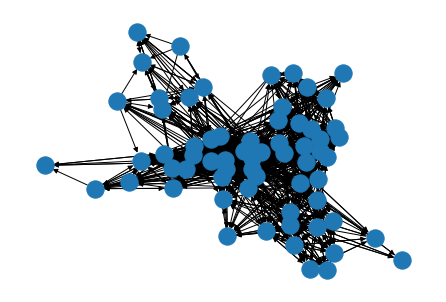

In [3]:
import networkx as nx
import turicreate as tc
!wget https://s3.amazonaws.com/connectome-graphs/cat/mixed.species_brain_1.graphml -O ./datasets/mixed.species_brain_1.graphml
g =nx.read_graphml('./datasets/mixed.species_brain_1.graphml')
print(nx.info(g))

nx.write_gexf(g, "./datasets/brain.gexf")
#nx.draw(g)


In [47]:
import turicreate as tc
import numpy as np
def common_friends(g,u,v):
    if not g.has_node(u) or not g.has_node(v):
        return None
    return set(g.neighbors(u)) & set(g.neighbors(v))
import operator
def find_friends_of_friends(g, v):
    "Returns a set with all the friends of friends of v that are not friends of v"
    friends_set = set(g.neighbors(v))
    friends_of_friends_set = set()
    for f in friends_set:
        friends_of_friends_set |= set(g.neighbors(f))
    friends_of_friends_set -= friends_set
    friends_of_friends_set -= {v}
    return friends_of_friends_set


def rank_friends_of_friends(g, v):
    rank_dict = {}
    vertices_set = find_friends_of_friends(g, v)
    for u in vertices_set:
        rank_dict[u] = len(common_friends(g, v, u))
    #3sorted_d = sorted(rank_dict.items(), key=operator.itemgetter(1), reverse=True)
    #return sorted_d
    return rank_dict

#rank_friends_of_friends()
sf = tc.SFrame()
for node in g:
    ranks = rank_friends_of_friends(g,node)
    for out_v in ranks.keys():
        row = {'in_v':[node], 'out_v': [out_v], 'rank':[ranks[out_v]]}
        sf = sf.append(tc.SFrame(data = row))
max_rank = sf['rank'].mean() + sf['rank'].std()*0.5
print(max_rank)
sf['class'] = sf.apply(lambda x:x['rank']>max_rank)
src = [str(x) for (x,y) in g.edges()]
dst =[str(y) for (x,y) in g.edges()]
sf =sf.append(tc.SFrame({'in_v':src, 'out_v': dst, 'rank':np.ones(len(src),dtype=int),'class':np.ones(len(src),dtype=int)}))
sf.print_rows(30)

6.104774070832252
+------+-------+------+-------+
| in_v | out_v | rank | class |
+------+-------+------+-------+
|  n0  |  n55  |  1   |   0   |
|  n0  |  n22  |  0   |   0   |
|  n0  |  n40  |  5   |   0   |
|  n0  |  n61  |  0   |   0   |
|  n0  |  n48  |  1   |   0   |
|  n0  |  n12  |  3   |   0   |
|  n0  |  n36  |  3   |   0   |
|  n0  |  n53  |  1   |   0   |
|  n0  |  n64  |  0   |   0   |
|  n0  |  n15  |  3   |   0   |
|  n0  |  n38  |  0   |   0   |
|  n0  |  n13  |  2   |   0   |
|  n0  |  n51  |  3   |   0   |
|  n0  |  n41  |  2   |   0   |
|  n0  |   n8  |  3   |   0   |
|  n0  |   n7  |  6   |   0   |
|  n0  |  n50  |  3   |   0   |
|  n0  |  n17  |  1   |   0   |
|  n0  |  n60  |  0   |   0   |
|  n0  |  n62  |  0   |   0   |
|  n0  |  n47  |  2   |   0   |
|  n0  |  n14  |  7   |   1   |
|  n0  |  n42  |  7   |   1   |
|  n0  |  n58  |  5   |   0   |
|  n0  |  n26  |  5   |   0   |
|  n0  |  n21  |  0   |   0   |
|  n0  |  n59  |  3   |   0   |
|  n0  |   n6  |  4   

In [50]:

train_set,valid_set = sf.remove_column('rank').random_split(0.7)

model = tc.classifier.create(train_set, validation_set=valid_set, target='class')


PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 2471

Number of classes           : 2

Number of feature columns   : 2

Number of unpacked features : 2

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.034654     | 0.598138          | 0.585474            | 0.675748          | 0.682325            |

| 2         | 0.052727     | 0.604209          | 0.585474            | 0.661820          | 0.673272            |

| 3         | 0.076924     | 0.642250          | 0.612046            | 0.650688          | 0.666127            |

| 4         | 0.096851     | 0.643059          | 0.614703            | 0.640112          | 0.658980            |

| 5         | 0.114084     | 0.658843          | 0.621789            | 0.630946          | 0.653611            |

| 10        | 0.214932     | 0.735735          | 0.681134            | 0.593143          | 0.626634            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 2471

Number of classes           : 2

Number of feature columns   : 2

Number of unpacked features : 2

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.034714     | 0.600567          | 0.588131            | 0.660609          | 0.677325            |

| 2         | 0.051675     | 0.628086          | 0.608503            | 0.652960          | 0.672027            |

| 3         | 0.065483     | 0.636180          | 0.610275            | 0.650682          | 0.668851            |

| 4         | 0.080050     | 0.636180          | 0.608503            | 0.649676          | 0.667227            |

| 5         | 0.101977     | 0.636180          | 0.609389            | 0.648604          | 0.666365            |

| 10        | 0.179671     | 0.618373          | 0.605846            | 0.648535          | 0.667016            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 2471

Number of classes           : 2

Number of feature columns   : 2

Number of unpacked features : 2

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.021743     | 0.598138          | 0.585474            | 0.654850          | 0.675993            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 2471

Number of classes           : 2

Number of feature columns   : 2

Number of unpacked features : 2

Number of coefficients    : 129

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 5.000000  | 0.001140     | 0.778227          | 0.759079            |

| 1         | 8        | 0.615579  | 0.008320     | 0.792796          | 0.770593            |

| 2         | 9        | 0.769473  | 0.011087     | 0.794011          | 0.776794            |

| 3         | 10       | 0.961842  | 0.012593     | 0.729664          | 0.721878            |

| 4         | 17       | 0.966822  | 0.018106     | 0.802509          | 0.784765            |

| 9         | 32       | 0.844625  | 0.031537     | 0.779846          | 0.767050            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 2471

Number of classes           : 2

Number of feature columns   : 2

Number of unpacked features : 2

Number of coefficients      : 129

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.004216     | 0.783084          | 0.763508            |

| 2         | 3        | 0.010350     | 0.781870          | 0.773251            |

| 3         | 4        | 0.013493     | 0.783084          | 0.773251            |

| 4         | 5        | 0.021031     | 0.782679          | 0.773251            |

| 5         | 6        | 0.029145     | 0.782679          | 0.773251            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.6811337466784765
PROGRESS: RandomForestClassifier          : 0.6058458813108946
PROGRESS: DecisionTreeClassifier          : 0.5854738706820195
PROGRESS: SVMClassifier                   : 0.7670504871567759
PROGRESS: LogisticClassifier              : 0.7732506643046945
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.


In [51]:
!pip install karateclub


  Using cached karateclub-1.2.3-py3-none-any.whl
  Using cached gensim-4.1.2-cp36-cp36m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.1 MB)
  Using cached python-Levenshtein-0.12.2.tar.gz (50 kB)
  Preparing metadata (setup.py) ... done
  Using cached PyGSP-0.5.1-py2.py3-none-any.whl (1.8 MB)
  ERROR: Command errored out with exit status 1:
   command: /home/amityu/code/BigData/turi_env/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ixxqc4js/python-levenshtein_4a10b9cf727745d9bf9150ecbac9e4e7/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ixxqc4js/python-levenshtein_4a10b9cf727745d9bf9150ecbac9e4e7/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-a2sslzms
       cwd: /tmp/pip-install-

**Question 2:** Use three different centrality algorithms to identify managers at Enron.
    Evaluate the precision@10 of the algorithms, i.e. how many managers attained the top-10 highest ranks (30pt). Draw
    the network and visualize one of the centrality measures (10pt)
